In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 12.2.13 Simulating from the Variance Gamma Model

In this example, we show how to simulate the price of an asset using the Variance Gamma model:

In [ ]:
def var_gamma(sigma, v, theta, S0, T, r, q, n, N):
    '''
    sigma: volatility
    v: variance of the Gamma process
    theta: drift
    S0: spot price
    T: time horizon
    r: risk-ree rate
    q: dividend yield
    n: number of simulated paths
    N: number of time steps
    '''
    dt = T/N
    w = np.log(1-theta*v-0.5*v*sigma**2)/v
    price_vec = np.empty(n)

    for i in range(n):

        lns0 = np.log(S0)
        xt = 0

        for j in range(N):

            gamma = np.random.gamma(dt/v, v)
            z = np.random.normal(0,1)
            xt += theta*gamma + sigma*np.sqrt(gamma)*z

            Tj = dt*(j+1)
            lnst = lns0 + (r-q+w)*Tj + xt

        price = np.exp(lnst)
        price_vec[i] = price

    return price_vec

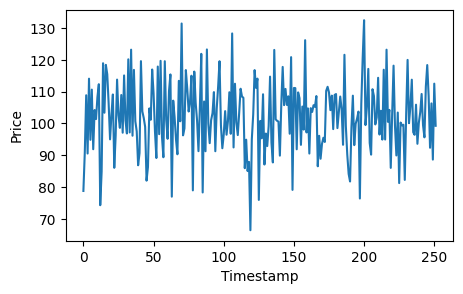

In [ ]:
# example
sigma = 0.1
v = 0.2
theta = -0.1
S0 = 100
T = 1
r = 0.05
q = 0.02
n = 252
N = 1000

price_vec = var_gamma(sigma, v, theta, S0, T, r, q, n, N)

plt.figure(figsize=(5,3))
plt.plot(price_vec)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.show()

### 12.2.16 Simulation in Practice: Impact of Skew on Lookback Options Values in the Heston Model

In this example, we show how to simulate the price and payoff of a lookback option and an European option using the Heston model:

In [ ]:
def lookback_heston_simu(S0, K, r, T, v0, sigma, k, theta, rho, n, N, flag='call'):
    '''
    S0: spot price
    K: strike price (fixed)
    r: risk-free rate
    T: time horizon
    v0: initial variance
    sigma: volatility
    k: mean reversion rate
    theta: long-term mean variance
    rho: correlation between the asset price and its variance
    n: number of simulated paths
    N: number of time steps
    flag: call or put
    '''

    dt = T/N
    mean = (0,0)
    cov = [[dt,rho*dt],[rho*dt,dt]]
    st_vec = np.empty(n)
    vt_vec = np.empty(n)
    payoff_vec = np.empty(n)
    price_vec = np.empty(n)

    for i in range(n):

        x = np.random.multivariate_normal(mean,cov,(N,1))
        st = S0
        vt = v0
        st_path = np.empty(N)

        for j in range(N):
            dst = r*st*dt + np.sqrt(vt)*st*x[j][0][0]
            dvt = k*(theta-vt)*dt + sigma*np.sqrt(vt)*x[j][0][1]
            st += dst
            st_path[j] = st
            vt += dvt
            if vt<0:
                vt = -vt

        assert flag=='call' or flag=='put', 'Please correctly specify the option type (call or put).'
        if flag=='call':
            payoff_vec[i] = max(max(st_path)-K,0)
        else:
            payoff_vec[i] = max(K-min(st_path),0)

        price_vec[i] = payoff_vec[i]*np.exp(-r*T)
        st_vec[i] = st
        vt_vec[i] = vt

    return price_vec

In [ ]:
def european_heston_simu(S0, K, r, T, v0, sigma, k, theta, rho, n, N, flag='call'):
    '''
    S0: spot price
    K: strike price (fixed)
    r: risk-free rate
    T: time horizon
    v0: initial variance
    sigma: volatility
    k: mean reversion rate
    theta: long-term mean variance
    rho: correlation between the asset price and its variance
    n: number of simulated paths
    N: number of time steps
    flag: call or put
    '''

    dt = T/N
    mean = (0,0)
    cov = [[dt,rho*dt],[rho*dt,dt]]
    st_vec = np.empty(n)
    vt_vec = np.empty(n)
    payoff_vec = np.empty(n)
    price_vec = np.empty(n)

    for i in range(n):

        x = np.random.multivariate_normal(mean,cov,(N,1))
        st = S0
        vt = v0
        st_path = np.empty(N)

        for j in range(N):
            dst = r*st*dt + np.sqrt(vt)*st*x[j][0][0]
            dvt = k*(theta-vt)*dt + sigma*np.sqrt(vt)*x[j][0][1]
            st += dst
            st_path[j] = st
            vt += dvt
            if vt<0:
                vt = -vt

        assert flag=='call' or flag=='put', 'Please correctly specify the option type (call or put).'
        if flag=='call':
            payoff_vec[i] = max(st_path[-1]-K,0)
        else:
            payoff_vec[i] = max(K-st_path[-1],0)

        price_vec[i] = payoff_vec[i]*np.exp(-r*T)
        st_vec[i] = st
        vt_vec[i] = vt

    return price_vec

Note that here we rely on the reflection approach to handling potential negative volatilities.

We then show how the price of both lookback calls and puts at different strikes vary as the volatility skew changes. Please keep in mind that the following cell may take some time to finish:

In [ ]:
# assign parameter values
S0 = 100
r = 0.05
T = 1
v0 = 0.08
sigma = 0.2
k = 0.7
theta = 0.1
rho = 0
n = 50000
N = 250
K_list = [90, 105, 120]
rho_list = np.arange(-1, 1, 0.25)

# initialize dataframes for storing prices under different K's and rho's
df_call = pd.DataFrame()
df_put = pd.DataFrame()

# calculate option prices using the function defined above
for K in K_list:

    call_price_list = []
    put_price_list = []

    for rho in rho_list:

        call_price = lookback_heston_simu(S0, K, r, T, v0, sigma, k, theta, rho, n, N, 'call').mean()
        put_price = lookback_heston_simu(S0, K, r, T, v0, sigma, k, theta, rho, n, N, 'put').mean()

        call_price_list.append(call_price)
        put_price_list.append(put_price)

    df_call[K] = pd.Series(call_price_list)
    df_put[K] = pd.Series(put_price_list)

df_call.index = rho_list
df_call.index.name = 'rho'
df_call.columns.name='strike'
df_put.index = rho_list
df_put.index.name = 'rho'
df_put.columns.name='strike'

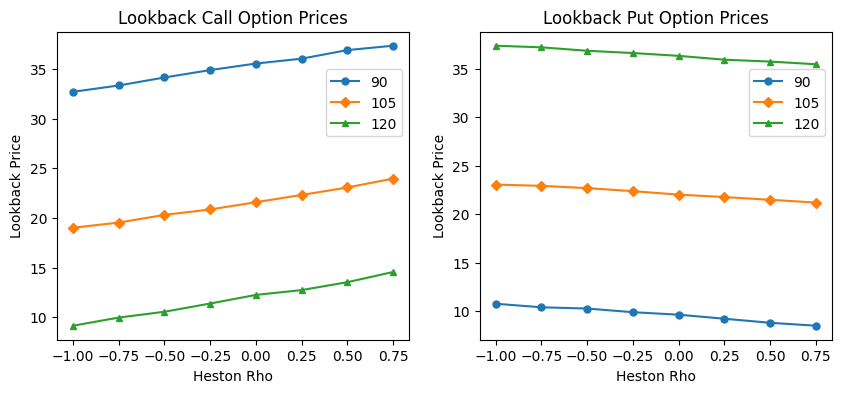

In [ ]:
# visualization
fig, axes = plt.subplots(1,2,figsize=(10,4))
markers = ['o', 'D', '^']

for i, column in enumerate(df_call.columns):
    axes[0].plot(df_call.index, df_call[column], marker=markers[i % len(markers)], markersize=5, label=column)
for i, column in enumerate(df_put.columns):
    axes[1].plot(df_put.index, df_put[column], marker=markers[i % len(markers)], markersize=5, label=column)

axes[0].set_xlabel('Heston Rho')
axes[0].set_ylabel('Lookback Price')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 0.9))
axes[0].set_title('Lookback Call Option Prices')
axes[1].set_xlabel('Heston Rho')
axes[1].set_ylabel('Lookback Price')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 0.9))
axes[1].set_title('Lookback Put Option Prices')

plt.show()

Finally, we plot the ratio of a lookback option price to the analogous European option to isolate th relationship between lookbacks and skew. Again, please keep in mind that the following cell may take some time to finish:

In [ ]:
df_call_e = pd.DataFrame()
df_put_e = pd.DataFrame()

for K in K_list:

    call_price_list_e = []
    put_price_list_e = []

    for rho in rho_list:

        call_price = european_heston_simu(S0, K, r, T, v0, sigma, k, theta, rho, n, N, 'call').mean()
        put_price = european_heston_simu(S0, K, r, T, v0, sigma, k, theta, rho, n, N, 'put').mean()

        call_price_list_e.append(call_price)
        put_price_list_e.append(put_price)

    df_call_e[K] = pd.Series(call_price_list_e)
    df_put_e[K] = pd.Series(put_price_list_e)

df_call_e.index = rho_list
df_call_e.index.name = 'rho'
df_call_e.columns.name='strike'
df_put_e.index = rho_list
df_put_e.index.name = 'rho'
df_put_e.columns.name='strike'

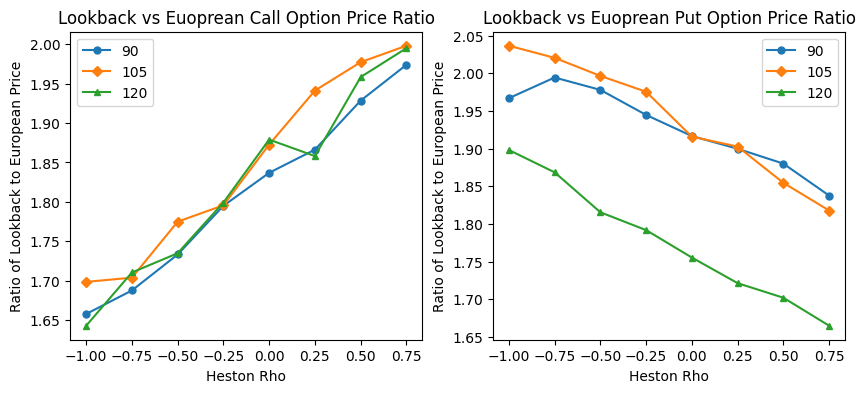

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
markers = ['o', 'D', '^']

for i, column in enumerate(df_call.columns):
    axes[0].plot(df_call.index, df_call[column]/df_call_e[column], marker=markers[i % len(markers)], markersize=5, label=column)
for i, column in enumerate(df_put.columns):
    axes[1].plot(df_put.index, df_put[column]/df_put_e[column], marker=markers[i % len(markers)], markersize=5, label=column)

axes[0].set_xlabel('Heston Rho')
axes[0].set_ylabel('Ratio of Lookback to European Price')
axes[0].legend(loc='upper left')
axes[0].set_title('Lookback vs Euoprean Call Option Price Ratio')
axes[1].set_xlabel('Heston Rho')
axes[1].set_ylabel('Ratio of Lookback to European Price')
axes[1].legend(loc='upper right')
axes[1].set_title('Lookback vs Euoprean Put Option Price Ratio')

plt.show()

### 12.3.13 American vs. European Digital Options in Practice

In this example, we calculate the price of an American call by solving the Black-Scholes PDE using the explicit discretization scheme:

In [ ]:
def solve_bs_pde(smax, K, T, N, M, sigma, r):

    '''
    smax: price upper boundary
    K: strike price
    T: time horizon
    N: number of time grids
    M: number of strike grids
    sigma: volatility (constant)
    r: risk-free rate
    '''

    ht = T/N
    hs = smax/M
    t = np.arange(0, T+ht, ht)
    s = np.arange(0, smax+hs, hs)

    d = 1-(sigma**2)*(s**2)*ht/(hs**2)-r*ht
    l = 0.5*(sigma**2)*(s**2)*ht/(hs**2)-r*s*ht/(2*hs)
    u = 0.5*(sigma**2)*(s**2)*ht/(hs**2)+r*s*ht/(2*hs)

    A = np.matrix(np.zeros((M-1,M-1)))
    diag = d[1:]
    upperDiag = u[1:M-1]
    lowerDiag = l[2:M]
    for i in range(len(upperDiag)):
        A[i,i+1] = upperDiag[i]
        A[i+1,i] = lowerDiag[i]
    for i in range(M-1):
        A[i,i] = diag[i]
    vec_eigenvalue = np.linalg.eigvals(A)

    b = u[M-1]*(s[M]-K*np.exp(-r*(T-t)))

    diff = s-K
    diff[diff<0]=0
    ter_c = np.matrix(diff[1:M]).T
    cont_val = ter_c

    for i in range(N, -1, -1):
        bb = np.append(np.zeros(M-2),b[i]).reshape(M-1,1)
    exercise_val = np.maximum(s[1:-1]-K, np.zeros(M-1)).reshape(M-1,1)
    cont_val = A @ cont_val + bb
    # exercise if exercise value exceeds continuation value
    vec_c = np.maximum(cont_val, exercise_val)

    return vec_c

Function `solve_bs_pde()` returns the price vector that denotes the option price at time 0 with different underlying asset prices. We can plug in the current value of the asset price to obtain our estimated model price via a PDE approximation.

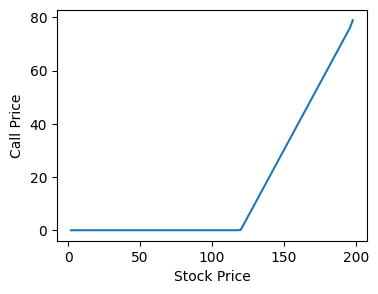

In [ ]:
# example
smax = 200
K = 120
N = 100
M = 100
sig = 0.05
r = 0.05

vec_c = solve_bs_pde(smax, K, T, N, M, sig, r)
hs = smax/M
s = np.arange(0, smax+hs, hs)[1:M]

plt.figure(figsize=(4,3))
plt.plot(s, vec_c)
plt.xlabel('Stock Price')
plt.ylabel('Call Price')
plt.show()